<a href="https://colab.research.google.com/github/satvik-dixit/explainability_SER/blob/main/final_wavlm_large_SER_explainability_interspeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability of DL-based embeddings




### Importing packages

In [ ]:
!pip install -q tqdm==4.60.0
!pip install -q opensmile
!pip install torch torchaudio transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from random import sample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import random
import torch
import opensmile
import seaborn as sns

from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, f1_score, make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
f1 = make_scorer(f1_score, average='weighted')
from transformers import AutoFeatureExtractor, AutoModel

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Upload kaggle.json to download the EmoDB dataset

! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Loading audio files and extracting metadata

Includes downloading the dataset, loading audio files, resampling audio files, extracting metadata



### Defining a function for loading and resampling audio files

In [ ]:
np.random.seed(42)

# Defining a function for loading and resampling audio files

def load_audio_files(audio_files, resampling_frequency=16000, audio_list=None):
  '''
  Loads and resamples audio files

  Parameters
  ------------
  audio_files: string
      The paths of the wav files
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''
  # Making audio_list
  if audio_list is None:
    audio_list = []

  # Resampling
  for audio in audio_files:
    signal, fs = librosa.load(audio, sr=resampling_frequency)
    audio_list.append(torch.from_numpy(signal))

  return audio_list


### Loading and resampling audiofiles and collecting metadata on EmoDB dataset

In [ ]:
# Load dataset
! kaggle datasets download -q -d piyushagni5/berlin-database-of-emotional-speech-emodb
! unzip -q berlin-database-of-emotional-speech-emodb.zip

# Load and resample audio files
audio_files = glob(os.path.join('/content/wav','*.wav'))
audio_list = load_audio_files(audio_files, resampling_frequency=16000)

# Making speakers list and labels list
speakers = []
labels = []
for audio_file in audio_files:
  file_name = audio_file.split('/')[3]
  speakers.append(int(file_name[:2]))
  labels.append(file_name[5:6])

label_dict = {'A': 'fear', 'L': 'boredom', 'E': 'disgust', 'T': 'sadness', 'W': 'anger', 'N': 'neutrality', 'F': 'joy'}
labels = [label_dict[emotion] for emotion in labels]

print('Number of audio files: {}'.format(len(audio_list)))
print('Number of speaker classes: {}'.format(len(set(speakers))))
print('Speaker classes: {}'.format(set(speakers)))
print('Number of speakers: {}'.format(len(speakers)))
print('Number of label classes: {}'.format(len(set(labels))))
print('Label classes: {}'.format(set(labels)))
print('Number of labels: {}'.format(len(labels)))


replace wav/03a01Fa.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Number of audio files: 535
Number of speaker classes: 10
Speaker classes: {3, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Number of speakers: 535
Number of label classes: 7
Label classes: {'joy', 'neutrality', 'disgust', 'boredom', 'anger', 'sadness', 'fear'}
Number of labels: 535


## Embedding Extraction
Includes extracting features using
- Deep learning based methods: WavLM
- DSP based methods: openSMILE eGeMAPS

### Audio embeddings extraction functions

In [ ]:
# Defining a function for generating audio embedding extraction models

def audio_embeddings_model(model_name):
    '''
    Generates model for embedding extraction

    Parameters
    ------------
    mode_name: string
        The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'

    Returns
    ------------
    model: object
        The embedding extraction model
    '''
    if model_name=='compare':
        model = opensmile.Smile(
            feature_set=opensmile.FeatureSet.ComParE_2016,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
    elif model_name=='egemaps':
        model = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
    return model


# Defining a function for embedding exctraction from the audio list

def audio_embeddings(audio_list, model_name, model, sampling_rate=16000):
    '''
    Loads and resamples audio files

    Parameters
    ------------
    audio_list: list
        A list of arrays, one array for each audio file
    model_name: string
        The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'
    model: object
        The embedding extraction model generated by audio_embeddings_model function
    sampling_rate: int
        The sampling rate, 16 kHz by default

    Returns
    ------------
    embeddings_array: array
        The array containg embeddings of all audio_files, dimension (number of audio files × n_feats)

    '''

    embeddings_list = []
    for i in tqdm(range(len(audio_list))):
        embeddings = model.process_signal(audio_list[i], sampling_rate)
        embeddings_list.append(torch.tensor(embeddings.values[0], dtype=torch.float32))
    embeddings_array = torch.stack(embeddings_list)
    return embeddings_array


def audio_embeddings_wavlm(audio_list, sampling_rate=16000):
  """
  Extracts embeddings from audio list using WavLM.

  Args:
      audio_list: List of audio file paths or audio data arrays.
      sampling_rate: Sampling rate of the audio (default: 16000).

  Returns:
      torch.Tensor: Embeddings for each audio file in the list.
  """
  embeddings_list = []
  for audio in tqdm(audio_list):

      inputs = feature_extractor(audio, sampling_rate=sampling_rate, return_tensors="pt")

      with torch.no_grad():
          outputs = model(**inputs)
          embeddings = outputs.last_hidden_state
          embeddings = torch.mean(embeddings, dim=1)
      embeddings_list.append(embeddings)

  return torch.cat(embeddings_list, dim=0)


def get_egemaps_feature_names():
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    egemaps_feature_names = model.column_names

    return egemaps_feature_names



In [ ]:
egemaps_feature_names = get_egemaps_feature_names()
def remove_substring(strings, target):
    return [s.replace(target, '') for s in strings]

egemaps_feature_names = remove_substring(egemaps_feature_names, '_sma3nz')
egemaps_feature_names = remove_substring(egemaps_feature_names, '_sma3')
print(egemaps_feature_names)

['F0semitoneFrom27.5Hz_amean', 'F0semitoneFrom27.5Hz_stddevNorm', 'F0semitoneFrom27.5Hz_percentile20.0', 'F0semitoneFrom27.5Hz_percentile50.0', 'F0semitoneFrom27.5Hz_percentile80.0', 'F0semitoneFrom27.5Hz_pctlrange0-2', 'F0semitoneFrom27.5Hz_meanRisingSlope', 'F0semitoneFrom27.5Hz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_meanFallingSlope', 'F0semitoneFrom27.5Hz_stddevFallingSlope', 'loudness_amean', 'loudness_stddevNorm', 'loudness_percentile20.0', 'loudness_percentile50.0', 'loudness_percentile80.0', 'loudness_pctlrange0-2', 'loudness_meanRisingSlope', 'loudness_stddevRisingSlope', 'loudness_meanFallingSlope', 'loudness_stddevFallingSlope', 'spectralFlux_amean', 'spectralFlux_stddevNorm', 'mfcc1_amean', 'mfcc1_stddevNorm', 'mfcc2_amean', 'mfcc2_stddevNorm', 'mfcc3_amean', 'mfcc3_stddevNorm', 'mfcc4_amean', 'mfcc4_stddevNorm', 'jitterLocal_amean', 'jitterLocal_stddevNorm', 'shimmerLocaldB_amean', 'shimmerLocaldB_stddevNorm', 'HNRdBACF_amean', 'HNRdBACF_stddevNorm', 'logRelF0-H1-H2_ame

### Audio embeddings extraction on EmoDB

In [ ]:
# WavLM
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-large")
model = AutoModel.from_pretrained("microsoft/wavlm-large")
embeddings_array_WavLM = audio_embeddings_wavlm(audio_list)
print(embeddings_array_WavLM.shape)

# EmoDB egemaps
model = audio_embeddings_model(model_name='egemaps')
embeddings_array_egemaps = audio_embeddings(audio_list, model_name='egemaps', model=model)

# ---------------------------------------------------------------------------------------------------

# Verify Phase_2
models = ['WavLM', 'egemaps']
embeddings_arrays = {'WavLM': embeddings_array_WavLM, 'egemaps':embeddings_array_egemaps}

for model in models:
  print()
  print()
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the embeddings array is {}'.format(embeddings_arrays[model].shape))


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/wavlm-large were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMModel were not initialized from the model checkpoint at microsoft/wavlm-large and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

torch.Size([535, 1024])


100%|██████████| 535/535 [01:51<00:00,  4.78it/s]



MODEL: WavLM

The shape of the embeddings array is torch.Size([535, 1024])


MODEL: egemaps

The shape of the embeddings array is torch.Size([535, 88])


In [ ]:

# Defining a function for speaker normalisation using standard scaler

def speaker_normalisation(embeddings_array, speakers):
    '''
    Normalises embeddings_array for each speaker

    Parameters
    ------------
    embeddings_array: array
        The array of embeddings, one row for each audio file
    speakers: list
        The list of speakers

    Returns
    ------------
    embeddings_array: array
        The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)

    '''
    speaker_ids = set(speakers)
    for speaker_id in speaker_ids:
        speaker_embeddings_indices = np.where(np.array(speakers)==speaker_id)[0]
        speaker_embeddings = embeddings_array[speaker_embeddings_indices,:]
        scaler = StandardScaler()
        normalised_speaker_embeddings = scaler.fit_transform(speaker_embeddings)
        embeddings_array[speaker_embeddings_indices] = torch.tensor(normalised_speaker_embeddings).float()
    return embeddings_array

embeddings_arrays['WavLM'] = speaker_normalisation(embeddings_arrays['WavLM'], speakers)
embeddings_arrays['egemaps'] = speaker_normalisation(embeddings_arrays['egemaps'], speakers)


## Classification and Feature Importance Functions


In [ ]:
# function for dividing the dataset into dictionaries with emotions as keys and embeddings/labels/speakers as values

def label_division(embeddings_array, labels, required_labels, speakers):
    np.random.seed(42)
    final_embeddings_dict = {}
    final_labels_dict = {}
    final_speakers_list_dict = {}

    for label in required_labels:
        label_indices = np.where(np.array(labels) == label)[0]
        label_embeddings = embeddings_array[label_indices, :]
        final_speakers_list_dict[label] = list(np.array(speakers)[label_indices])
        final_embeddings_dict[label] = label_embeddings
        final_labels_dict[label] = [label] * len(label_indices)

    return final_embeddings_dict, final_labels_dict, final_speakers_list_dict


In [ ]:
# function for combining one emotion (50%) and the rest of the 5 emotions (10% each)

def emotion_all_merger(emotion, other_emotions, wavlm_embeddings_dict, egemaps_embeddings_dict, speakers_dict, num=45):

  np.random.seed(42)
  print(len(speakers_dict[emotion]), num)
  emo_indices = np.random.choice(len(speakers_dict[emotion]), size=num, replace=False)

  wavlm_embeddings = wavlm_embeddings_dict[emotion][emo_indices]
  egemaps_embeddings = egemaps_embeddings_dict[emotion][emo_indices]
  speakers = [speakers_dict[emotion][i] for i in emo_indices]
  labels = [1]*num

  for em in other_emotions:
    em_indices = np.random.choice(len(speakers_dict[em]), size=int(num/len(other_emotions)), replace=False)
    em_speakers = [speakers_dict[em][i] for i in em_indices]
    wavlm_embeddings_emo = wavlm_embeddings_dict[em][em_indices]
    egemaps_embeddings_emo = egemaps_embeddings_dict[em][em_indices]
    # print('egemaps_embeddings_emo.shape', egemaps_embeddings_emo.shape)
    # print('wavlm_embeddings_emo.shape', wavlm_embeddings_emo.shape)

    wavlm_embeddings = np.concatenate((wavlm_embeddings, wavlm_embeddings_emo), axis=0)
    egemaps_embeddings = np.concatenate((egemaps_embeddings, egemaps_embeddings_emo), axis=0)
    # print('w_embeddings.shape', w_embeddings.shape)
    # print('e_embeddings.shape', e_embeddings.shape)

    speakers = speakers + em_speakers
    labels = labels + [0]*int(num/len(other_emotions))

  return wavlm_embeddings, egemaps_embeddings, labels, speakers


In [ ]:


wavlm_embeddings_dict, wavlm_labels_dict, wavlm_speakers_list_dict = label_division(embeddings_array=embeddings_array_WavLM, labels=labels, required_labels=['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust'], speakers=speakers)
eGeMAPS_embeddings_dict, eGeMAPS_labels_dict, eGeMAPS_speakers_list_dict = label_division(embeddings_array=embeddings_array_egemaps, labels=labels, required_labels=['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust'], speakers=speakers)

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

wavlm_embeddings_all = {}
egemaps_embeddings_all = {}
speakers_all = {}
labels_all = {}

for e in emotions:
    wavlm_embeddings, egemaps_embeddings, labels, speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], wavlm_embeddings_dict=wavlm_embeddings_dict, egemaps_embeddings_dict=eGeMAPS_embeddings_dict, speakers_dict=eGeMAPS_speakers_list_dict, num=45)
    wavlm_embeddings_all[e] = wavlm_embeddings
    egemaps_embeddings_all[e] = egemaps_embeddings
    speakers_all[e] = speakers
    labels_all[e] = labels
    print(e)
    print('-'*20)
    print('speakers:', speakers)
    print('labels_all:', labels_all)
    print()

127 45
anger
--------------------
speakers: [13, 14, 10, 14, 12, 13, 14, 10, 16, 9, 15, 12, 13, 11, 13, 9, 9, 14, 13, 15, 16, 9, 8, 8, 16, 9, 10, 16, 3, 16, 11, 8, 14, 15, 12, 12, 15, 8, 8, 3, 13, 11, 10, 15, 3, 14, 3, 10, 8, 12, 15, 14, 16, 10, 13, 3, 12, 12, 13, 9, 13, 11, 16, 16, 10, 14, 3, 8, 8, 16, 14, 8, 16, 15, 16, 3, 11, 8, 8, 11, 16, 9, 9, 15, 16, 9, 14, 13, 10, 16]
labels_all: {'anger': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

69 45
fear
--------------------
speakers: [14, 10, 13, 11, 10, 10, 16, 14, 15, 10, 13, 14, 8, 8, 14, 11, 11, 11, 12, 14, 12, 10, 14, 10, 8, 11, 3, 11, 12, 11, 14, 3, 16, 13, 11, 11, 8, 10, 13, 13, 11, 15, 14, 3, 15, 14, 15, 11, 13, 10, 8, 14, 15, 11, 8, 11, 14, 13, 3, 13, 15, 11, 15, 15, 12, 16, 10, 3, 8, 11, 16, 14, 14, 16, 

In [ ]:
# Function for ranking all features in decreasing order of feature importance using coefficients

def feature_importance_method(X, y, feature_names, trained_model):
  coef_abs = abs(trained_model.coef_[0])
  feature_indices = np.argsort(coef_abs)[::-1]
  sorted_importances = [(feature_names[i], coef_abs[i]) for i in feature_indices]
  return sorted_importances


In [ ]:
# Function for nested cross validation

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']
Performance ={'eGeMAPS':{e:[] for e in emotions}, 'WavLM_all':{e:[] for e in emotions}, 'WavLM_top_features':{e:[] for e in emotions}}

def classification_pipeline(embeddings, speakers, labels_list, feature_names):

    np.random.seed(42)

    X = embeddings
    y = labels_list
    groups = speakers

    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

    # Outer cross-validation loop
    outer_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
    outer_scores = []
    feats_array = []
    for train_index, test_index in outer_cv.split(X, y, groups):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

        # Inner cross-validation loop for hyperparameter tuning
        inner_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
        grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=inner_cv)
        grid_search.fit(X_train, y_train, groups=[groups[i] for i in train_index])

        # Get the best hyperparameters found in the inner loop
        best_params = grid_search.best_params_

        # Fit the model with the best hyperparameters on the training data
        model = LogisticRegression( **best_params)

        # Standardize X_train and transform X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='binary')
        outer_scores.append(score)

    # Compute and print the mean F1 score across all outer folds
    mean_f1 = np.round(100*np.mean(outer_scores), 1)
    return model, mean_f1



In [ ]:
def find_x_at_n_percentile(x_values, y_values, n):
    percentile = np.percentile(y_values, n)
    for i, y in enumerate(y_values):
        if y >= percentile:
            x_at_nth_percentile = x_values[i]
            break

    return x_at_nth_percentile

# eGeMAPS

In [ ]:
eGeMAPS_fi_dict = {}
egemaps_top_features_df = {}

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

for e in emotions:

  ege_embeddings, ege_labels, ege_speakers = egemaps_embeddings_all[e], labels_all[e], speakers_all[e]
  trained_model, result = classification_pipeline(embeddings=ege_embeddings, speakers=ege_speakers, labels_list=ege_labels, feature_names=egemaps_feature_names)
  Performance['eGeMAPS'][e] = result

  fi = feature_importance_method(X=ege_embeddings, y=ege_labels, feature_names=egemaps_feature_names, trained_model=trained_model)
#   eGeMAPS_fi_dict[e] = [list(egemaps_feature_names).index(tup[0]) for tup in fi]
  eGeMAPS_top_fi_features = [[tup[0], np.round(tup[1], 3)] for tup in fi]
  table = {'Feature': [element[0] for element in eGeMAPS_top_fi_features], 'Importance': [element[1] for element in eGeMAPS_top_fi_features]}
  egemaps_top_features_df[e] = pd.DataFrame(table)


## Most important egemaps features (according to coef)

In [ ]:
df = egemaps_top_features_df[emotions[0]]
df.head(10)


,Feature,Importance
0,HNRdBACF_amean,0.072
1,alphaRatioV_amean,0.069
2,mfcc4_amean,0.067
3,HNRdBACF_stddevNorm,0.066
4,hammarbergIndexV_stddevNorm,0.061
5,mfcc4V_amean,0.061
6,logRelF0-H1-A3_amean,0.060
7,slopeUV0-500_amean,0.060
8,hammarbergIndexV_amean,0.060
9,F3bandwidth_stddevNorm,0.059


In [ ]:
df = egemaps_top_features_df[emotions[1]]
df.head(10)


,Feature,Importance
0,F0semitoneFrom27.5Hz_stddevNorm,0.086
1,alphaRatioUV_amean,0.080
2,shimmerLocaldB_stddevNorm,0.079
3,F3bandwidth_amean,0.079
4,HNRdBACF_amean,0.075
5,loudness_amean,0.074
6,loudness_percentile20.0,0.074
7,mfcc1_amean,0.073
8,loudness_percentile50.0,0.072
9,F0semitoneFrom27.5Hz_pctlrange0-2,0.068


In [ ]:
df = egemaps_top_features_df[emotions[2]]
df.head(10)


,Feature,Importance
0,mfcc4_amean,1.389
1,loudnessPeaksPerSec,1.299
2,StddevUnvoicedSegmentLength,1.285
3,mfcc1_amean,1.040
4,jitterLocal_amean,1.029
5,logRelF0-H1-H2_amean,0.956
6,shimmerLocaldB_amean,0.928
7,F0semitoneFrom27.5Hz_percentile20.0,0.919
8,F0semitoneFrom27.5Hz_percentile50.0,0.896
9,F0semitoneFrom27.5Hz_stddevRisingSlope,0.879


In [ ]:
df = egemaps_top_features_df[emotions[3]]
df.head(10)


,Feature,Importance
0,alphaRatioV_stddevNorm,0.321
1,F1bandwidth_amean,0.298
2,F0semitoneFrom27.5Hz_pctlrange0-2,0.256
3,loudness_stddevRisingSlope,0.248
4,F2bandwidth_amean,0.241
5,spectralFluxV_stddevNorm,0.227
6,F0semitoneFrom27.5Hz_percentile80.0,0.226
7,mfcc1_stddevNorm,0.206
8,mfcc1V_stddevNorm,0.204
9,F0semitoneFrom27.5Hz_percentile50.0,0.199


In [ ]:
df = egemaps_top_features_df[emotions[4]]
df.head(10)


,Feature,Importance
0,slopeV0-500_amean,0.086
1,F3amplitudeLogRelF0_amean,0.078
2,F2amplitudeLogRelF0_amean,0.077
3,StddevUnvoicedSegmentLength,0.076
4,F1amplitudeLogRelF0_amean,0.076
5,hammarbergIndexV_amean,0.073
6,slopeUV0-500_amean,0.073
7,F1amplitudeLogRelF0_stddevNorm,0.073
8,MeanUnvoicedSegmentLength,0.073
9,F0semitoneFrom27.5Hz_percentile80.0,0.070


In [ ]:
df = egemaps_top_features_df[emotions[5]]
df.head(10)


,Feature,Importance
0,slopeV0-500_amean,1.445
1,F1frequency_stddevNorm,1.329
2,F3frequency_amean,1.193
3,shimmerLocaldB_stddevNorm,1.191
4,mfcc4_amean,1.097
5,mfcc3V_amean,1.056
6,F2frequency_amean,1.020
7,VoicedSegmentsPerSec,0.974
8,F3frequency_stddevNorm,0.943
9,F3bandwidth_amean,0.815


# WavLM

In [ ]:
wavlm_feature_names = [i for i in range(1024)]
wavlm_fi_dict = {}
emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

for e in emotions:

  wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]

  trained_model, result = classification_pipeline(embeddings=wavlm_embeddings, speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
  Performance['WavLM_all'][e] = result

  fi = feature_importance_method(X=wavlm_embeddings, y=wavlm_labels, feature_names=wavlm_feature_names, trained_model=trained_model)
  wavlm_fi_dict[e] = [tup[0] for tup in fi]


In [ ]:
num_wavlm_features = {e: 1 for e in emotions}

def plot_top_performance(e, importance_dict):
  wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]
  top_scores = []
  bottom_scores = []
  rest_scores = []

  total = 1024

  for n in range(10, int(total/2), 10):

    top_features = importance_dict[e][:n]
    best_model, top_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, top_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    top_scores.append(top_f1)

    rest_features = importance_dict[e][n+1:]
    best_model, rest_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, rest_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    rest_scores.append(rest_f1)

    bottom_features = importance_dict[e][total-n-1:]
    best_model, bottom_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, bottom_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    bottom_scores.append(bottom_f1)

  n_features = range(10, int(total/2), 10)
  fig, ax = plt.subplots()

  ax.plot(n_features, top_scores, label='Top dimensions')
  ax.plot(n_features, rest_scores, label='Rest dimensions')
  ax.plot(n_features, bottom_scores, label='Bottom dimensions')

  ax.set_xlabel('Number of dimensions')
  ax.set_ylabel('F1 score')
  ax.set_title(e)
  ax.legend()

  percentile = np.percentile(top_scores, 100)
  # ax.axhline(y=percentile, color='r')

  ax.set_ylim(0, 100)
  x_val = find_x_at_n_percentile(n_features, top_scores, 100)
  ax.scatter(x_val, percentile, marker='x', color='red')

  return x_val, percentile



## Plot top performance

{'anger': [532, 753, 336, 267, 10, 435, 134, 291, 286, 251, 911, 826, 781, 717, 676, 3, 246, 191, 368, 277, 569, 193, 507, 371, 797, 176, 697, 241, 809, 202, 622, 178, 526, 548, 38, 846, 154, 109, 903, 36, 640, 961, 25, 537, 973, 539, 700, 582, 907, 731, 470, 91, 397, 873, 398, 897, 533, 320, 473, 938, 100, 275, 942, 782, 125, 754, 834, 497, 331, 257, 361, 758, 567, 839, 367, 723, 187, 503, 266, 115, 221, 389, 88, 292, 328, 761, 195, 329, 348, 63, 830, 161, 1004, 752, 353, 653, 472, 681, 710, 207, 737, 19, 789, 904, 633, 501, 871, 16, 498, 11, 172, 955, 9, 122, 376, 46, 262, 707, 593, 768, 902, 483, 656, 760, 335, 284, 726, 550, 179, 493, 617, 693, 800, 856, 380, 934, 743, 801, 175, 405, 950, 316, 641, 171, 932, 401, 318, 223, 849, 564, 145, 634, 895, 477, 598, 678, 773, 345, 740, 303, 650, 568, 210, 531, 816, 842, 394, 290, 592, 967, 766, 850, 951, 1, 446, 528, 486, 404, 466, 514, 912, 619, 166, 874, 305, 869, 631, 649, 162, 82, 60, 807, 822, 414, 314, 529, 611, 958, 421, 570, 861, 46

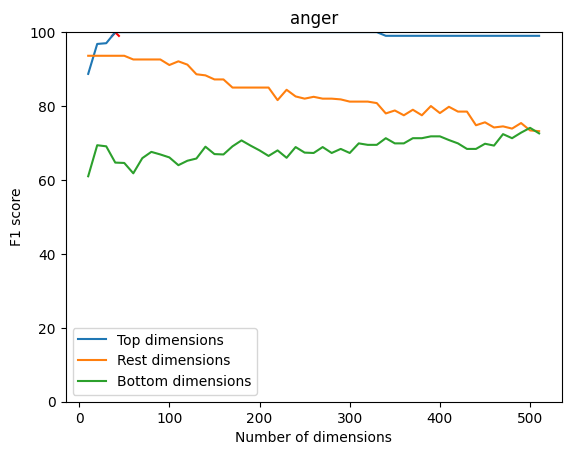

In [ ]:
emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']
print(wavlm_fi_dict)
num_wavlm_features[emotions[0]], Performance['WavLM_top_features'][emotions[0]] = plot_top_performance(emotions[0], wavlm_fi_dict)


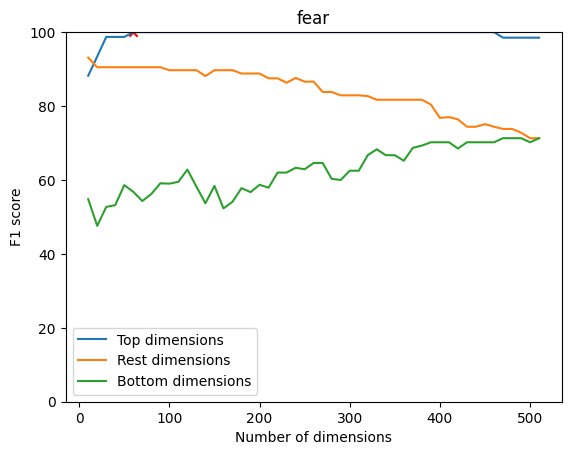

In [ ]:

num_wavlm_features[emotions[1]], Performance['WavLM_top_features'][emotions[1]]  = plot_top_performance(emotions[1], wavlm_fi_dict)


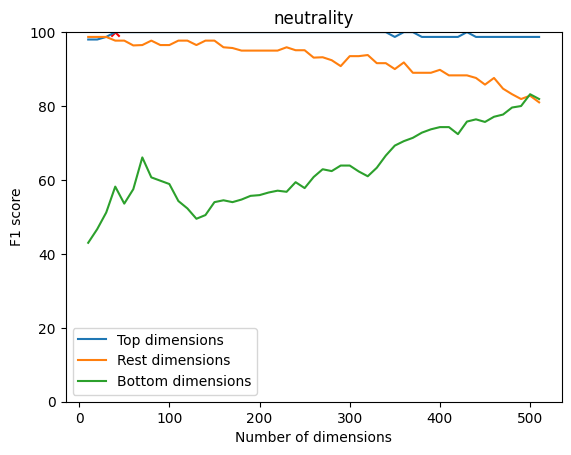

In [ ]:

num_wavlm_features[emotions[2]], Performance['WavLM_top_features'][emotions[2]] = plot_top_performance(emotions[2], wavlm_fi_dict)


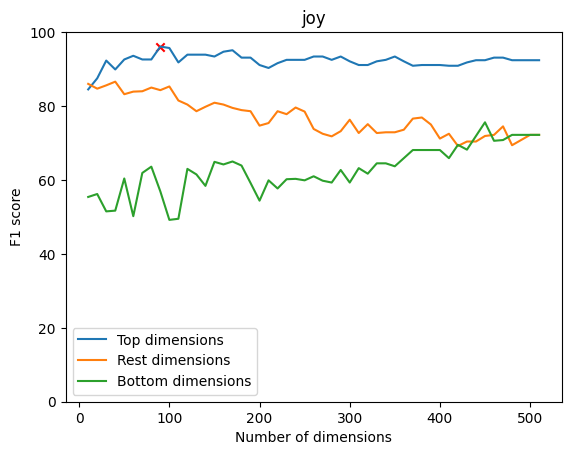

In [ ]:

num_wavlm_features[emotions[3]], Performance['WavLM_top_features'][emotions[3]] = plot_top_performance(emotions[3], wavlm_fi_dict)


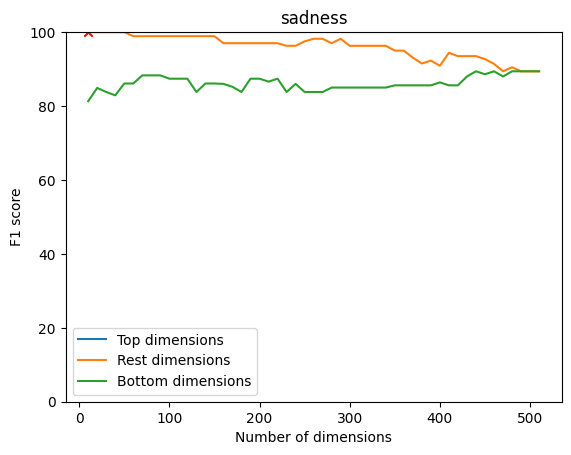

In [ ]:

num_wavlm_features[emotions[4]], Performance['WavLM_top_features'][emotions[4]] = plot_top_performance(emotions[4], wavlm_fi_dict)


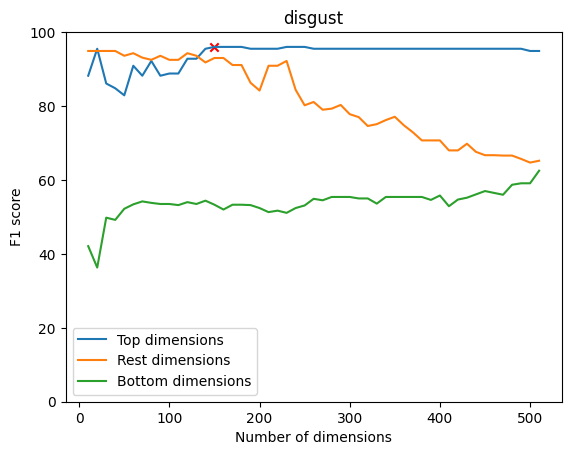

In [ ]:

num_wavlm_features[emotions[5]], Performance['WavLM_top_features'][emotions[5]] = plot_top_performance(emotions[5], wavlm_fi_dict)


In [ ]:
print(num_wavlm_features)


{'anger': 40, 'fear': 60, 'neutrality': 40, 'joy': 90, 'sadness': 10, 'disgust': 150}


# Predicting Functions

In [ ]:
# def get_pearson_correlation(x, y):
#     # Calculate mean of x and y
#     mean_x = np.mean(x)
#     mean_y = np.mean(y)

#     # Calculate covariance and standard deviation of x and y
#     cov_xy = np.sum((x - mean_x) * (y - mean_y))
#     std_x = np.sqrt(np.sum((x - mean_x)**2))
#     std_y = np.sqrt(np.sum((y - mean_y)**2))

#     # Calculate Pearson correlation coefficient
#     correlation = cov_xy / (std_x * std_y)

#     return correlation

# # Example usage
# x = np.array([1, 2, 3, 4, 5])
# y = np.array([2, 3, 4, 5, 6])

# print("Pearson correlation coefficient:", get_pearson_correlation(x, y))

def get_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Square Error (RMSE) between true and predicted values.

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: Root Mean Square Error (RMSE) value.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Calculate squared differences
    squared_diff = (y_true - y_pred) ** 2
    # Calculate mean squared error
    mse = np.mean(squared_diff)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    return rmse


In [ ]:
# num_wavlm_features = {'anger': 30, 'fear': 230, 'neutrality': 20, 'joy': 140, 'sadness': 20, 'disgust': 20}
# num_wavlm_features = {'anger': 40, 'fear': 70, 'neutrality': 20, 'joy': 60, 'sadness': 20, 'disgust': 30}
# {'anger': 80, 'fear': 130, 'neutrality': 50, 'joy': 40, 'sadness': 20, 'disgust': 50}

In [ ]:
# Defining a function for all steps
from sklearn.linear_model import Ridge

# Defining a function for hyperparameter tuning and getting the accuracy on the test set
def get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring='neg_mean_squared_error'): # check scoring

    pipe = Pipeline([('scaler', StandardScaler()),('model', regressor)])

    grid = GridSearchCV(pipe, param_grid=parameters, cv=5, n_jobs=-1, scoring=scoring)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    rmse = get_rmse(y_test, y_pred)

    return rmse

def prediction_pipeline(labeled_array, labels_list, regression_model, scoring='neg_root_mean_squared_error'):

  X_train, X_test, y_train, y_test = train_test_split(labeled_array, labels_list, test_size=0.20)

  if regression_model == 'ridge':
    regressor = Ridge()
    parameters = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    rmse = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  return rmse


# Getting performance for top features

In [ ]:
predicted_df_dict = {}

def top_wavlm_predict_ege(e):
  rmse_top_list = []
  rmse_all_list = []
  rmse_top_all = []
  rmse_top_squared_all = []

  wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]
  ege_embeddings, ege_labels, ege_speakers = egemaps_embeddings_all[e], labels_all[e], speakers_all[e]

  top_features = wavlm_fi_dict[e][:num_wavlm_features[e]]
  all_features = wavlm_fi_dict[e][:]


  for i in tqdm(range(88)):

    rmse_top = prediction_pipeline(wavlm_embeddings[:, top_features], ege_embeddings[:,i], regression_model='ridge')
    rmse_all = prediction_pipeline(wavlm_embeddings[:, all_features], ege_embeddings[:,i], regression_model='ridge')
    rmse_top_list.append(np.round(rmse_top, 3))
    rmse_all_list.append(np.round(rmse_all, 3))
    rmse_top_all.append(np.round(rmse_top/rmse_all, 3))
    rmse_top_squared_all.append(np.round(rmse_top**2/rmse_all, 3))

  prediction_metrics_dict = {'Feature':egemaps_feature_names, 'rmse_top_all':rmse_top_all, 'rmse_top_squared_all':rmse_top_squared_all, 'rmse_top': rmse_top_list, 'rmse_all':rmse_all_list}
  return prediction_metrics_dict


## Pearson tables

In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[0]))
sorted_df = df.sort_values(by='rmse_top_all', ascending=True)
predicted_df_dict[emotions[0]] = sorted_df


100%|██████████| 88/88 [00:39<00:00,  2.25it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all
63,slopeV0-500_stddevNorm,0.364,0.229,0.628,1.724
27,mfcc3_stddevNorm,0.465,0.209,0.450,0.967
75,mfcc4V_stddevNorm,0.492,0.114,0.232,0.472
9,F0semitoneFrom27.5Hz_stddevFallingSlope,0.528,0.223,0.422,0.800
7,F0semitoneFrom27.5Hz_stddevRisingSlope,0.564,0.426,0.754,1.337
66,spectralFluxV_amean,0.573,0.336,0.586,1.023
59,alphaRatioV_stddevNorm,0.669,0.665,0.994,1.486
73,mfcc3V_stddevNorm,0.733,0.530,0.723,0.986
78,slopeUV0-500_amean,0.739,0.343,0.463,0.627
41,F1frequency_stddevNorm,0.769,0.679,0.883,1.148


In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[1]))
sorted_df = df.sort_values(by='rmse_top_all', ascending=True)
predicted_df_dict[emotions[1]] = sorted_df


100%|██████████| 88/88 [00:28<00:00,  3.06it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all
65,slopeV500-1500_stddevNorm,0.488,0.139,0.285,0.583
83,MeanVoicedSegmentLengthSec,0.565,0.289,0.511,0.904
25,mfcc2_stddevNorm,0.599,0.307,0.512,0.854
73,mfcc3V_stddevNorm,0.611,0.338,0.553,0.904
21,spectralFlux_stddevNorm,0.616,0.303,0.492,0.798
30,jitterLocal_amean,0.638,0.437,0.685,1.073
68,mfcc1V_amean,0.651,0.235,0.360,0.554
61,hammarbergIndexV_stddevNorm,0.652,0.435,0.667,1.024
35,HNRdBACF_stddevNorm,0.655,0.355,0.543,0.829
62,slopeV0-500_amean,0.678,0.273,0.402,0.593


In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[2]))
sorted_df = df.sort_values(by='rmse_top_all', ascending=True)
predicted_df_dict[emotions[2]] = sorted_df


100%|██████████| 88/88 [00:27<00:00,  3.21it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all
23,mfcc1_stddevNorm,0.306,0.120,0.392,1.282
29,mfcc4_stddevNorm,0.403,0.253,0.629,1.563
32,shimmerLocaldB_amean,0.551,0.253,0.460,0.835
79,slopeUV500-1500_amean,0.583,0.326,0.558,0.957
27,mfcc3_stddevNorm,0.612,0.270,0.441,0.720
73,mfcc3V_stddevNorm,0.616,0.260,0.422,0.684
2,F0semitoneFrom27.5Hz_percentile20.0,0.632,0.202,0.319,0.505
22,mfcc1_amean,0.673,0.234,0.347,0.515
65,slopeV500-1500_stddevNorm,0.691,0.244,0.354,0.512
37,logRelF0-H1-H2_stddevNorm,0.721,0.298,0.413,0.573


In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[3]))
sorted_df = df.sort_values(by='rmse_top_all', ascending=True)
predicted_df_dict[emotions[3]] = sorted_df


100%|██████████| 88/88 [00:32<00:00,  2.72it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all
75,mfcc4V_stddevNorm,0.326,0.158,0.484,1.482
27,mfcc3_stddevNorm,0.369,0.212,0.573,1.553
73,mfcc3V_stddevNorm,0.423,0.339,0.801,1.894
23,mfcc1_stddevNorm,0.533,0.342,0.642,1.205
5,F0semitoneFrom27.5Hz_pctlrange0-2,0.573,0.384,0.669,1.168
79,slopeUV500-1500_amean,0.653,0.439,0.672,1.030
29,mfcc4_stddevNorm,0.675,0.592,0.877,1.299
37,logRelF0-H1-H2_stddevNorm,0.711,0.511,0.719,1.011
34,HNRdBACF_amean,0.712,0.480,0.674,0.946
53,F3frequency_stddevNorm,0.722,0.624,0.863,1.195


In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[4]))
sorted_df = df.sort_values(by='rmse_top_all', ascending=True)
predicted_df_dict[emotions[4]] = sorted_df


100%|██████████| 88/88 [00:28<00:00,  3.10it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all
73,mfcc3V_stddevNorm,0.214,0.079,0.371,1.733
75,mfcc4V_stddevNorm,0.287,0.141,0.490,1.708
37,logRelF0-H1-H2_stddevNorm,0.387,0.190,0.490,1.267
25,mfcc2_stddevNorm,0.392,0.111,0.284,0.726
27,mfcc3_stddevNorm,0.414,0.130,0.314,0.757
71,mfcc2V_stddevNorm,0.478,0.140,0.293,0.613
69,mfcc1V_stddevNorm,0.550,0.438,0.796,1.448
59,alphaRatioV_stddevNorm,0.585,0.241,0.412,0.704
9,F0semitoneFrom27.5Hz_stddevFallingSlope,0.607,0.530,0.872,1.436
79,slopeUV500-1500_amean,0.650,0.456,0.701,1.077


In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[5]))
sorted_df = df.sort_values(by='rmse_top_all', ascending=True)
predicted_df_dict[emotions[5]] = sorted_df


100%|██████████| 88/88 [00:32<00:00,  2.71it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all
65,slopeV500-1500_stddevNorm,0.341,0.164,0.480,1.407
59,alphaRatioV_stddevNorm,0.368,0.252,0.686,1.866
67,spectralFluxV_stddevNorm,0.509,0.301,0.593,1.165
30,jitterLocal_amean,0.576,0.323,0.560,0.972
76,alphaRatioUV_amean,0.597,0.282,0.471,0.790
49,F2bandwidth_stddevNorm,0.615,0.409,0.666,1.083
63,slopeV0-500_stddevNorm,0.629,0.307,0.487,0.775
66,spectralFluxV_amean,0.669,0.606,0.905,1.353
48,F2bandwidth_amean,0.684,0.534,0.781,1.141
16,loudness_meanRisingSlope,0.707,0.571,0.808,1.142


## Summary tables

In [ ]:
def summary_table_percentage(e):
    df1 = egemaps_top_features_df[e]
    df2 = predicted_df_dict[e]
    merged_df = pd.merge(df1, df2, on='Feature', how='inner')
    merged_df['Rank'] = merged_df.index + 1
    merged_df = merged_df[['Feature', 'Rank', 'Importance', 'rmse_top_all', 'rmse_top_squared_all', 'rmse_top', 'rmse_all']]
    return merged_df
print(emotions)

['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']


In [ ]:
def get_summary_plot_table(df, metric='rmse_top_all'):
    df_sorted = df.sort_values(by=metric, ascending=True)
    return df_sorted[['Feature', 'Rank', 'Importance', 'rmse_top_all', 'rmse_top_squared_all', 'rmse_top', 'rmse_all']].iloc[0:5]


In [ ]:
summary_plot_table_w = {}
summary_plot_table_uw = {}

top_predicted_egemaps_uw = {'anger':{}, 'fear':{}, 'neutrality':{}, 'joy':{}, 'sadness':{}, 'disgust':{}}
top_predicted_egemaps_w = {'anger':{}, 'fear':{}, 'neutrality':{}, 'joy':{}, 'sadness':{}, 'disgust':{}}

sets = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth']

for e in emotions:
    df = summary_table_percentage(e=e)
    summary_plot_table_uw[e] = get_summary_plot_table(df, 'rmse_top_all')
    summary_plot_table_w[e] = get_summary_plot_table(df, 'rmse_top_squared_all')

    for n, set_number in enumerate(sets):
        top_predicted_egemaps_uw[e][set_number] = list(df.sort_values(by='rmse_top_all', ascending=True).iloc[n * 11:n * 11 + 11].Feature.values)
        top_predicted_egemaps_w[e][set_number] = list(df.sort_values(by='rmse_top_squared_all', ascending=True).iloc[n * 11:n * 11 + 11].Feature.values)


In [ ]:
summary_plot_table_w_final = pd.concat([summary_plot_table_w[e].iloc[:5] for e in emotions], ignore_index=True, axis=0)
summary_plot_table_uw_final = pd.concat([summary_plot_table_uw[e].iloc[:5] for e in emotions], ignore_index=True, axis=0)

summary_plot_table_w_final['Emotion'] = ['anger']*5 + ['fear']*5 + ['neutrality']*5 + ['joy']*5 + ['sadness']*5 + ['disgust']*5
summary_plot_table_uw_final['Emotion'] = ['anger']*5 + ['fear']*5 + ['neutrality']*5 + ['joy']*5 + ['sadness']*5 + ['disgust']*5


In [ ]:
summary_plot_table_uw_final

,Feature,Rank,Importance,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,Emotion
0,slopeV0-500_stddevNorm,80,0.005,0.364,0.229,0.628,1.724,anger
1,mfcc3_stddevNorm,85,0.001,0.465,0.209,0.450,0.967,anger
2,mfcc4V_stddevNorm,75,0.008,0.492,0.114,0.232,0.472,anger
3,F0semitoneFrom27.5Hz_stddevFallingSlope,81,0.005,0.528,0.223,0.422,0.800,anger
4,F0semitoneFrom27.5Hz_stddevRisingSlope,66,0.015,0.564,0.426,0.754,1.337,anger
5,slopeV500-1500_stddevNorm,71,0.014,0.488,0.139,0.285,0.583,fear
6,MeanVoicedSegmentLengthSec,78,0.008,0.565,0.289,0.511,0.904,fear
7,mfcc2_stddevNorm,88,0.001,0.599,0.307,0.512,0.854,fear
8,mfcc3V_stddevNorm,77,0.008,0.611,0.338,0.553,0.904,fear
9,spectralFlux_stddevNorm,15,0.058,0.616,0.303,0.492,0.798,fear


In [ ]:
summary_plot_table_w_final

,Feature,Rank,Importance,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,Emotion
0,mfcc4V_stddevNorm,75,0.008,0.492,0.114,0.232,0.472,anger
1,mfcc3_stddevNorm,85,0.001,0.465,0.209,0.450,0.967,anger
2,F0semitoneFrom27.5Hz_stddevFallingSlope,81,0.005,0.528,0.223,0.422,0.800,anger
3,slopeV0-500_stddevNorm,80,0.005,0.364,0.229,0.628,1.724,anger
4,slopeV0-500_amean,25,0.043,0.802,0.271,0.338,0.421,anger
5,slopeV500-1500_stddevNorm,71,0.014,0.488,0.139,0.285,0.583,fear
6,mfcc1V_amean,21,0.052,0.651,0.235,0.360,0.554,fear
7,mfcc2V_stddevNorm,26,0.047,0.812,0.255,0.314,0.387,fear
8,slopeV0-500_amean,87,0.001,0.678,0.273,0.402,0.593,fear
9,F2amplitudeLogRelF0_stddevNorm,36,0.035,0.744,0.287,0.386,0.519,fear


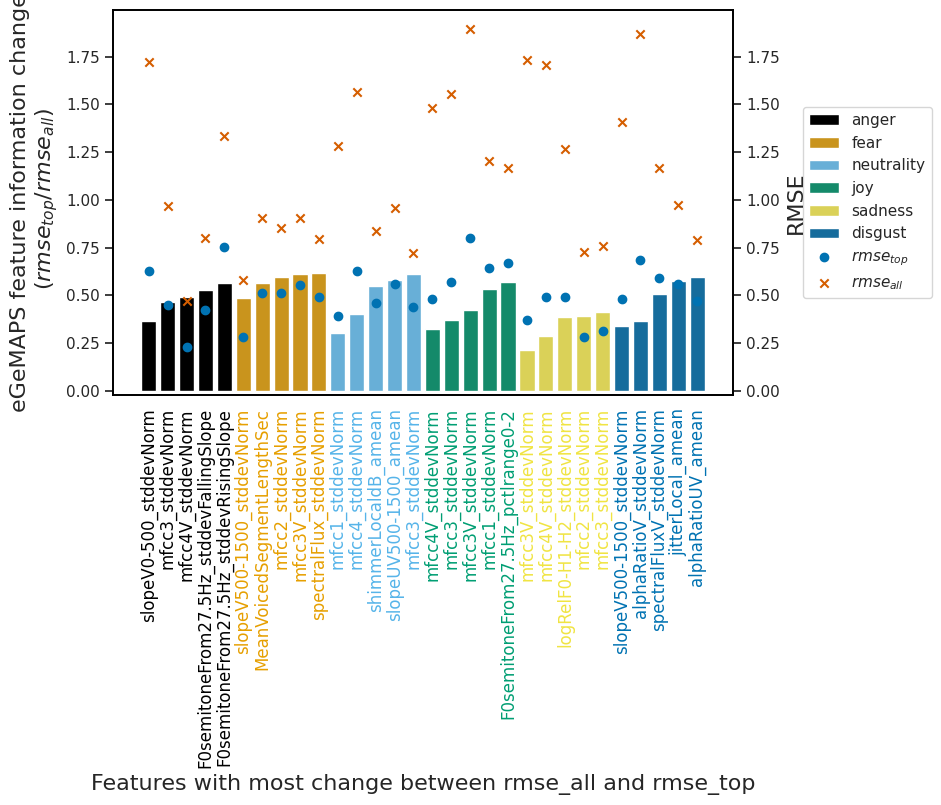

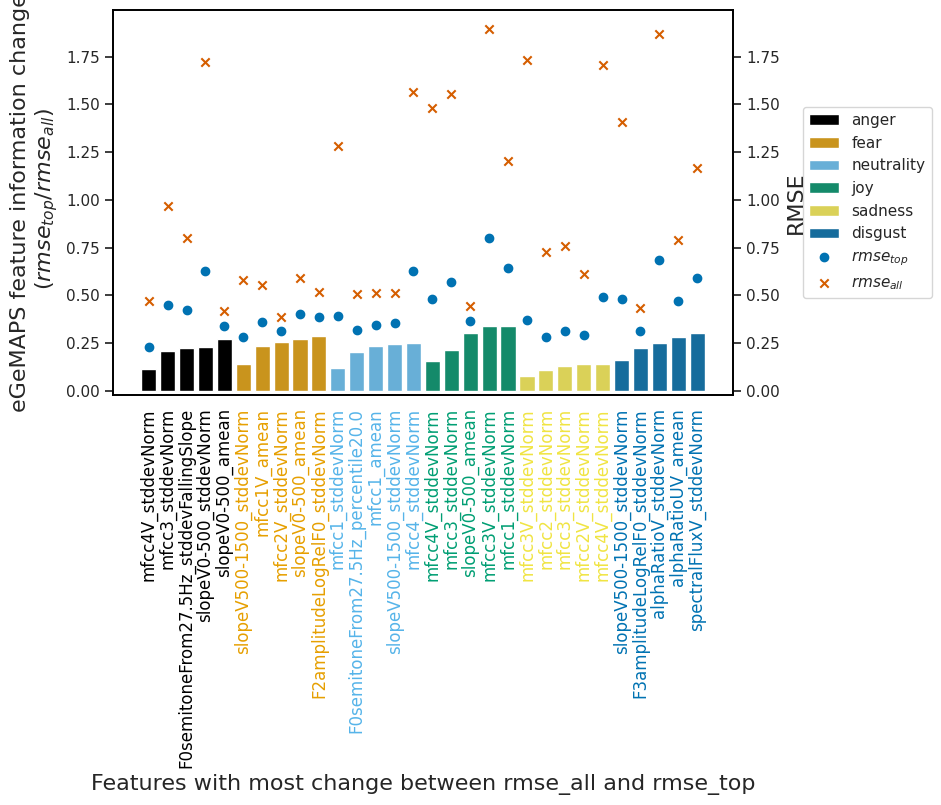

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def custom_bar_plot(data, colors, metric='rmse_top_all'):
    sns.set(rc={'figure.figsize':(8,5), 'axes.edgecolor': 'black', 'axes.facecolor':'white', 'figure.facecolor':'white'})

    # Your data and plot code
    ax = sns.barplot(data=data, x=data.index, y=metric, hue="Emotion", palette=colors)
    ax.set_xticklabels(data['Feature'])  # Set x label color to match the color of bars
    ax.set_xlabel('Features with most change between rmse_all and rmse_top', fontsize=16)

    # Increase x ticks size
    ax.tick_params(axis='x', which='major', labelsize=12, rotation=90)

    for i, tick_label in enumerate(ax.get_xticklabels()):
        tick_label.set_color(colors[i//5])

    # Change y label
    ax.set_ylabel('eGeMAPS feature information change\n ($rmse_{top}/rmse_{all})$', fontsize=16)

    # Create a secondary y-axis on the right
    ax2 = ax.twinx()
    ax2.set_ylabel('RMSE', fontsize=16)

    min_y_scatter = data[['rmse_top_all', 'rmse_top_squared_all', 'rmse_top', 'rmse_all']].values.min() - 0.1
    max_y_scatter = data[['rmse_top_all', 'rmse_top_squared_all', 'rmse_top', 'rmse_all']].values.max() + 0.1

    # Set the limits for both y axes to include scatter points
    ax.set_ylim(min_y_scatter, max_y_scatter)
    ax2.set_ylim(min_y_scatter, max_y_scatter)

    # Scatter plots with legends
    ax.scatter(data.index, data['rmse_top'], marker='o', color=colors[5], label='$rmse_{top}$')
    ax.scatter(data.index, data['rmse_all'], marker='x', color=colors[6], label='$rmse_{all}$')
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    ax.grid(False)
    ax2.grid(False)
    plt.show()

# Define the colors to be used
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

# Call the function with your data and colors
custom_bar_plot(summary_plot_table_uw_final, colors, metric='rmse_top_all')
custom_bar_plot(summary_plot_table_w_final, colors, metric='rmse_top_squared_all')

In [ ]:
def plot_top_ege_performance(e, top_predicted_egemaps):

  top_scores = []
  ege_embeddings, ege_labels, ege_speakers = egemaps_embeddings_all[e], labels_all[e], speakers_all[e]
  for n in range(8):
    top_features = top_predicted_egemaps[e][sets[n]]
    best_model, top_f1 = classification_pipeline(embeddings=ege_embeddings[:, top_features], speakers=ege_speakers, labels_list=ege_labels, feature_names=egemaps_feature_names)
    top_scores.append(top_f1)

  fig, ax = plt.subplots()
  n_features = range(0, 88, 11)
  ax.plot(n_features, top_scores, label='Top features')
  ax.set_xlabel('Number of features')
  ax.set_ylabel('F1 score')
  ax.set_title(e)
  ax.legend()
  ax.set_ylim(0, 100)


In [ ]:
print(top_predicted_egemaps_uw)
print(top_predicted_egemaps_w)

def get_indices(large_list, small_list):
    indices = []
    for item in small_list:
        try:
            index = large_list.index(item)
            indices.append(index)
        except ValueError:
            indices.append(None)
    return indices

for e in emotions:
    for n, set_number in enumerate(sets):
        top_predicted_egemaps_uw[e][set_number] = get_indices(egemaps_feature_names, top_predicted_egemaps_uw[e][set_number])
        top_predicted_egemaps_w[e][set_number] = get_indices(egemaps_feature_names, top_predicted_egemaps_w[e][set_number])

print(top_predicted_egemaps_uw)
print(top_predicted_egemaps_w)

{'anger': {'first': ['slopeV0-500_stddevNorm', 'mfcc3_stddevNorm', 'mfcc4V_stddevNorm', 'F0semitoneFrom27.5Hz_stddevFallingSlope', 'F0semitoneFrom27.5Hz_stddevRisingSlope', 'spectralFluxV_amean', 'alphaRatioV_stddevNorm', 'mfcc3V_stddevNorm', 'slopeUV0-500_amean', 'F1frequency_stddevNorm', 'jitterLocal_amean'], 'second': ['logRelF0-H1-A3_stddevNorm', 'mfcc4_stddevNorm', 'HNRdBACF_amean', 'slopeV500-1500_stddevNorm', 'slopeV0-500_amean', 'mfcc4_amean', 'mfcc1V_stddevNorm', 'F2bandwidth_stddevNorm', 'VoicedSegmentsPerSec', 'F0semitoneFrom27.5Hz_stddevNorm', 'F3bandwidth_stddevNorm'], 'third': ['logRelF0-H1-H2_stddevNorm', 'F2frequency_stddevNorm', 'equivalentSoundLevel_dBp', 'loudness_percentile50.0', 'spectralFluxV_stddevNorm', 'loudness_percentile80.0', 'logRelF0-H1-H2_amean', 'loudness_pctlrange0-2', 'F3frequency_amean', 'F0semitoneFrom27.5Hz_percentile20.0', 'F3bandwidth_amean'], 'fourth': ['loudness_stddevRisingSlope', 'F3frequency_stddevNorm', 'shimmerLocaldB_amean', 'F1bandwidth_a

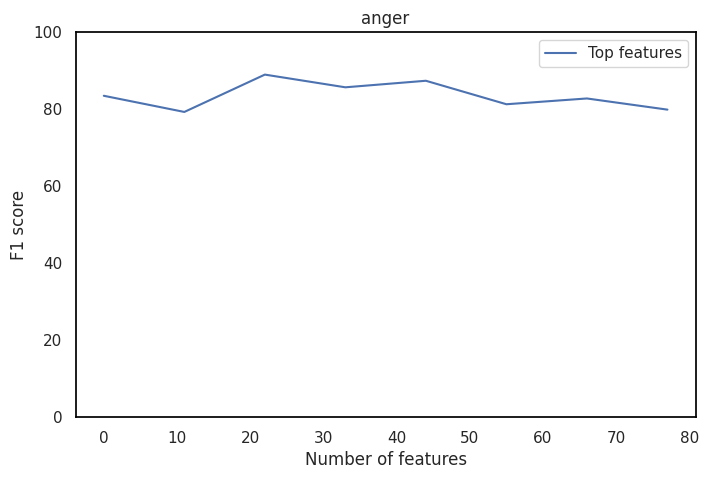

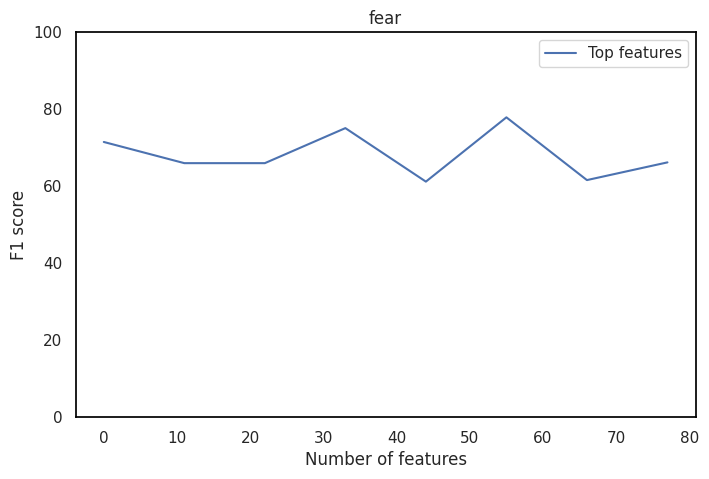

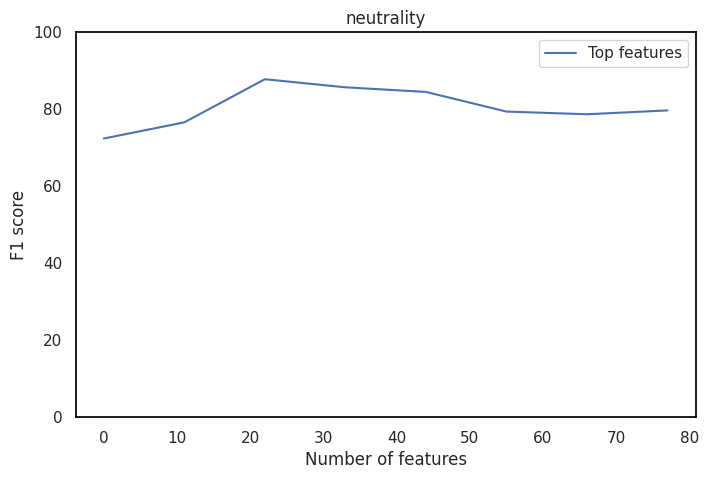

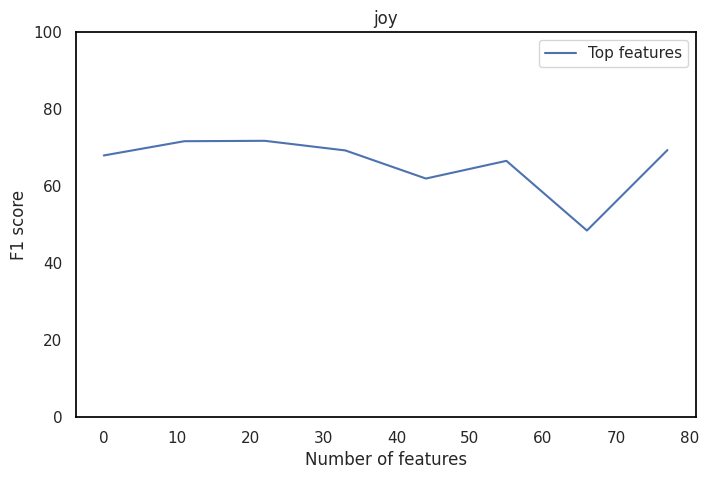

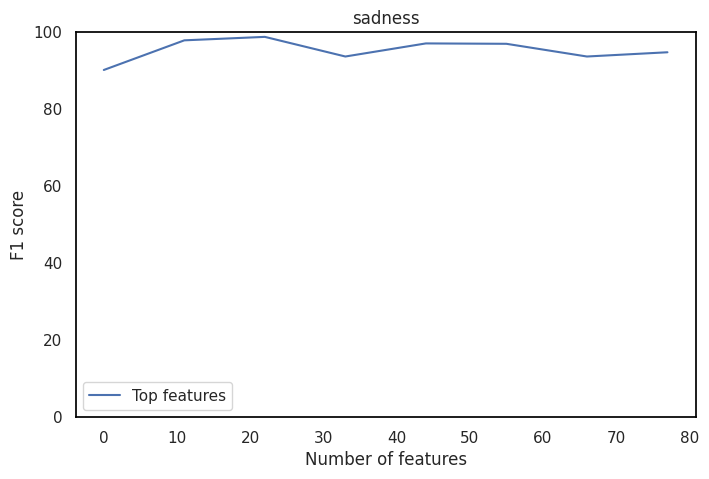

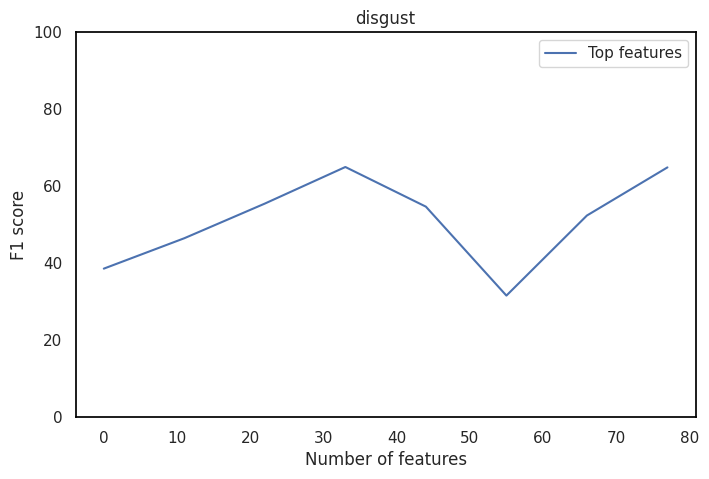

In [ ]:
for e in emotions:
    plot_top_ege_performance(e=e, top_predicted_egemaps=top_predicted_egemaps_w)

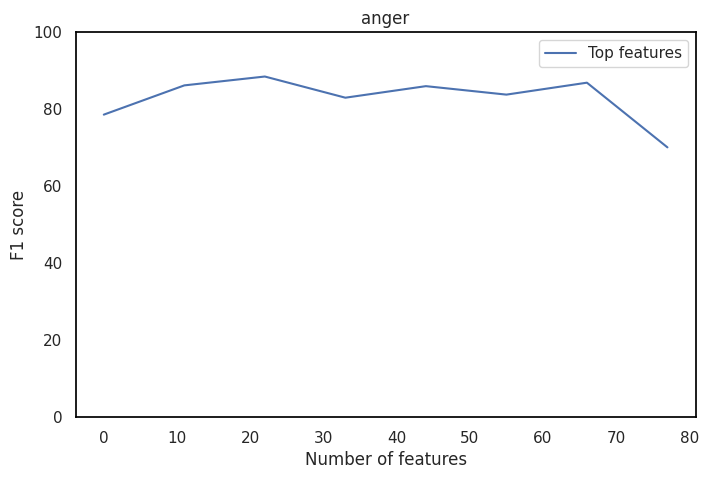

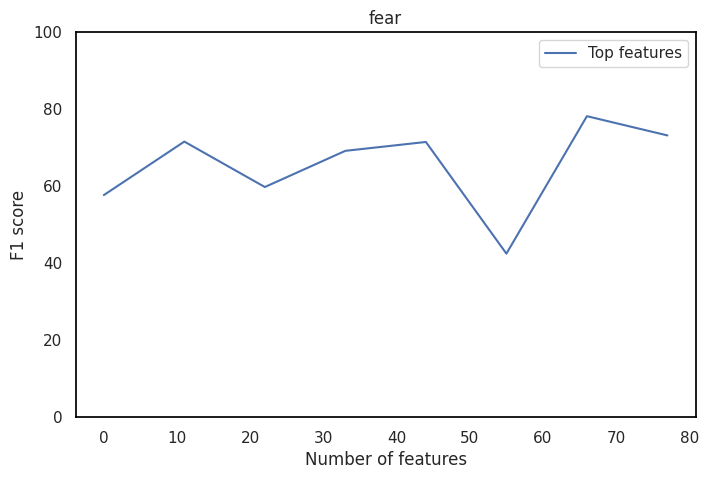

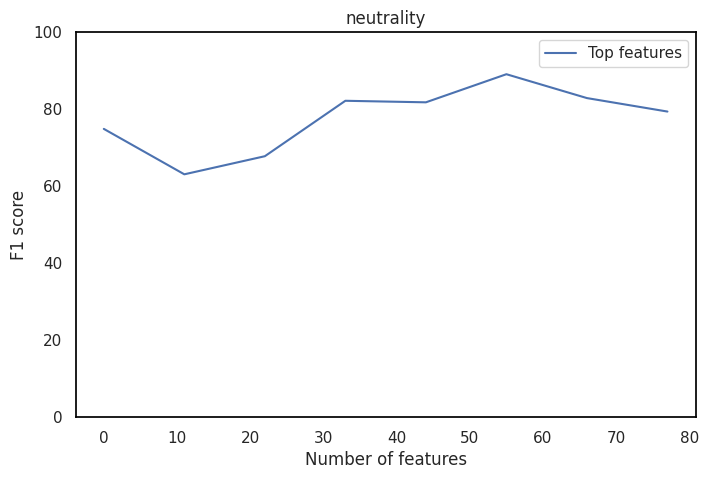

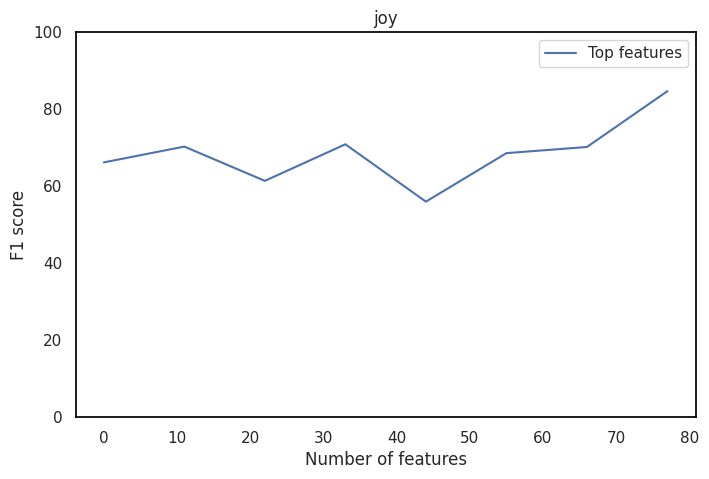

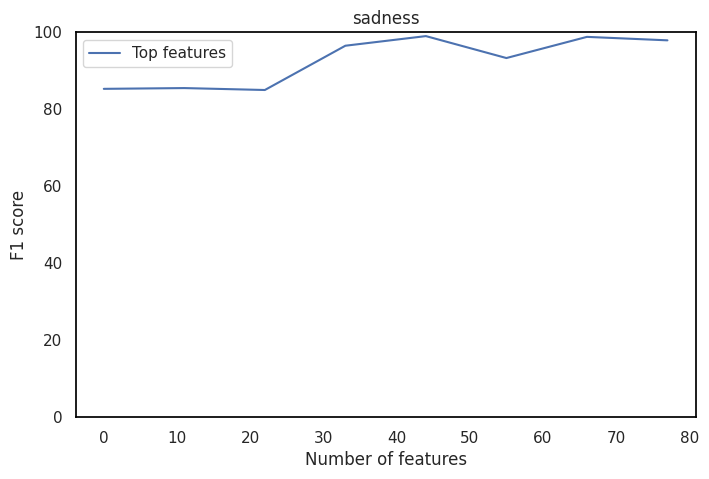

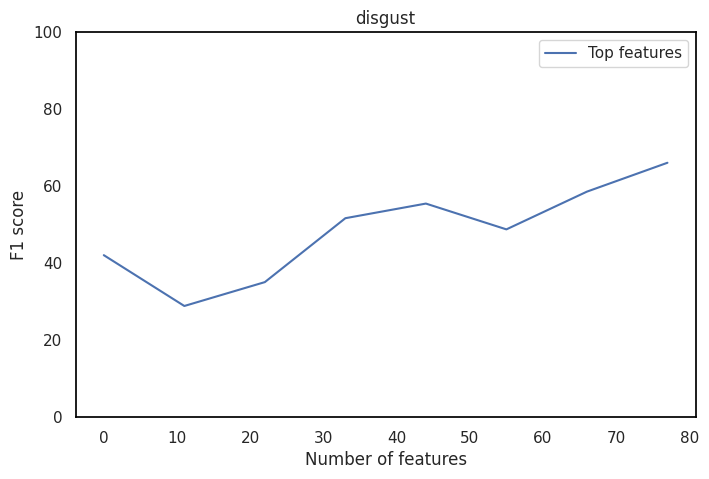

In [ ]:
for e in emotions:
    plot_top_ege_performance(e=e, top_predicted_egemaps=top_predicted_egemaps_uw)

# Performance Summary

In [ ]:
df = pd.DataFrame(Performance)
# new_column_names = {'eGeMAPS': 'eGeMAPS', 'Hybrid_BYOL-S_2048': 'Hybrid BYOL-S (all)', 'Hybrid_BYOL-S_top_features': 'Hybrid BYOL-S (top)'}
# df = df.rename(columns=new_column_names)
# df.round(2)
df

,eGeMAPS,WavLM_all,WavLM_top_features
anger,87.0,96.8,100.0
fear,81.1,93.1,100.0
neutrality,84.8,98.7,100.0
joy,71.3,86.0,96.1
sadness,98.8,100.0,100.0
disgust,60.0,94.9,96.0


In [ ]:
latex_table = df.head(10).to_latex(index=False)
print(latex_table)

\begin{tabular}{rrr}
\toprule
 eGeMAPS &  WavLM\_all &  WavLM\_top\_features \\
\midrule
    87.0 &       96.8 &               100.0 \\
    81.1 &       93.1 &               100.0 \\
    84.8 &       98.7 &               100.0 \\
    71.3 &       86.0 &                96.1 \\
    98.8 &      100.0 &               100.0 \\
    60.0 &       94.9 &                96.0 \\
\bottomrule
\end{tabular}

